In [1]:
%matplotlib inline

import seaborn as sns
sns.set_color_codes()

## NEMS4 Numerical Model
Lets read in the nems4 numerical model and prepare the predictions for use. The predictions are 12 hours $(t+12)$ in advance.

We convert the wind speed and direction into the u and v components. We will alternate between predicting the u and v components and just the pure wind direction.


In [2]:
import json
import pandas as pd
import numpy as np

def read_nems4(years, prediction_hours=12):
    readings=pd.DataFrame()
    for year in years:
        with open('data/NEMS4/{}.json'.format(year)) as json_data:
            d = json.load(json_data)
            if not readings.empty:
                readings = readings.append( pd.DataFrame(d['history_1h']))
            else:
                readings = pd.DataFrame(d['history_1h'])

    readings = readings.set_index('time')
    readings.index.name = 'timestamp'
    
    readings.index = pd.to_datetime(readings.index)
    # CEST to UTC
    readings.index -= pd.Timedelta(hours=2) 
    readings.index.tz = 'UTC'
    
    return readings
        
nems4_prediction_hours=12
nems4 = read_nems4(range(2010, 2016), nems4_prediction_hours)


# add wind components 
nems4['wind_u'] = -nems4.windspeed * np.sin(np.radians(nems4.winddirection))
nems4['wind_v'] = -nems4.windspeed * np.cos(np.radians(nems4.winddirection))

nems4 = nems4[['temperature', 'precipitation', 
               'relativehumidity', 'sealevelpressure', 
               'wind_u', 'wind_v', 'windspeed']]


nems4 = nems4.rename(columns={
    'windspeed': 'nems4_wind_speed', 
    'temperature': 'nems4_AT',
    'precipitation': 'nems4_precipitation',
    'relativehumidity': 'nems4_humidity',
    'sealevelpressure': 'nems4_pressure',
    'wind_u': 'nems4_wind_u',
    'wind_v': 'nems4_wind_v'})

# drop duplicates
print("Number of duplicates: {}".format(len(nems4.index.get_duplicates())))
nems4 = nems4[~nems4.index.duplicated(keep='first')]

print("Number of nems4 predictions: {}".format(len(nems4)))
print("Number of rows with nan: {}".format(np.count_nonzero(nems4.isnull())))

nems4.head()

Number of duplicates: 120
Number of nems4 predictions: 52608
Number of rows with nan: 0


,nems4_AT,nems4_precipitation,nems4_humidity,nems4_pressure,nems4_wind_u,nems4_wind_v,nems4_wind_speed
timestamp,,,,,,,
2009-12-31 22:00:00+00:00,11.97,0.0,55,994,8.693332,-2.329371,9.00
2009-12-31 23:00:00+00:00,11.04,0.0,54,995,8.389326,-1.936829,8.61
2010-01-01 00:00:00+00:00,9.63,0.0,55,996,8.795545,-2.522082,9.15
2010-01-01 01:00:00+00:00,8.70,0.0,56,996,9.296009,-1.806961,9.47
2010-01-01 02:00:00+00:00,7.88,0.0,62,996,9.601876,-1.693070,9.75


## Observation Data
We collect observation data from NOAA. NOAA makes obervation data from weather stations around the world available for access. It does so by year and station Id.

    # downloaded from "https://www1.ncdc.noaa.gov/pub/data/noaa/{year}/{usaf}-{wban}-{year}.gz"

    #!/bin/bash
    
    for year in `seq 2007 2016`; do
        wget https://www1.ncdc.noaa.gov/pub/data/noaa/$year/081810-99999-$year.gz
    done


Unfortunately the accuracy of the observation data is questionable and within a given station Id for Barcelona (081810) there are actually 4 different measurement locations.. We take the one that emits the readings most frequently. 

In [3]:
import gzip
from io import BytesIO
import pandas as pd
import numpy as np
from ish_parser import ish_parser
import matplotlib.pyplot as plt


parser = ish_parser()
def read_ish(usaf, wban, years):
    for year in years:
        path = "data/observations/{usaf}-{wban}-{year}.gz".format(year=year, usaf=usaf, wban=wban)
        with gzip.open(path) as gz:
            parser.loads(bytes.decode(gz.read()))

content = read_ish("081810", "99999", range(2010, 2016))
reports = parser.get_reports()

print("Done reading and parsing {} reports".format(len(reports)))


#{41.283, 41.29, 41.28, 41.293, 41.297}


# 41.293 started in Sept 2016
# 41.283 finished in Sept 2016
# they both have pressure readings

# 41.297 doesn't have pressure readings

station_latitudes = [41.283, 41.293] 
observations = pd.DataFrame.from_records(((r.datetime, 
                                           r.air_temperature.get_numeric(),
                                           (r.precipitation[0]['depth'].get_numeric() if r.precipitation else 0),
                                           r.humidity.get_numeric(),
                                           r.sea_level_pressure.get_numeric(),
                                           r.wind_speed.get_numeric(),
                                           r.wind_direction.get_numeric()) 
                                          for r in reports if r.latitude in station_latitudes and r.datetime.minute == 0),
                         columns=['timestamp', 'AT', 'precipitation', 'humidity', 'pressure', 'wind_speed', 'wind_direction'], 
                         index='timestamp')

# add wind components
observations['wind_u'] = -observations.wind_speed * np.sin(np.radians(observations.wind_direction))
observations['wind_v'] = -observations.wind_speed * np.cos(np.radians(observations.wind_direction))



# drop duplicates
print("Number of duplicates: {}".format(len(observations.index.get_duplicates())))
observations = observations[~observations.index.duplicated(keep='first')]


# fix missing intervals
filled_idx = pd.date_range(observations.index[0], observations.index[-1], freq='1H')
print("Number of missing recordings: {}".format(len(observations.index.difference(filled_idx))))

time_diff = np.diff(observations.index.astype(np.int64))
hour_nsec = 60*60*1e9 # one hour in nano seconds
print("Max missing time window (hours): {}".format((time_diff[time_diff != hour_nsec]).max()/hour_nsec))

observations = observations.reindex(filled_idx)
observations.index.name = 'timestamp'

# forward fill missing values (other option is interpolate)
print("Number of rows with nan forward filled: {}".format(np.count_nonzero(observations.isnull())))
observations.fillna(method='ffill', inplace=True)


print("Biggest jump in wind speed: {}".format(observations.wind_speed.diff().max()))

print("Number of observations: {}".format(len(observations)))


# rearrange predictive column (speed) to the end and drop direction
observations = observations[['AT', 'precipitation', 
                             'humidity', 'pressure', 
                             'wind_u', 'wind_v', 'wind_speed']]

observations.head()

Done reading and parsing 127185 reports
Number of duplicates: 1
Number of missing recordings: 0
Max missing time window (hours): 95.0
Number of rows with nan forward filled: 31941
Biggest jump in wind speed: 13.9
Number of observations: 52576


,AT,precipitation,humidity,pressure,wind_u,wind_v,wind_speed
timestamp,,,,,,,
2010-01-01 00:00:00+00:00,10.8,0.0,46.0,995.6,8.075424,1.423915,8.2
2010-01-01 01:00:00+00:00,11.0,0.0,50.0,995.6,8.567827,1.510739,8.7
2010-01-01 02:00:00+00:00,11.0,0.0,47.0,995.6,7.090616,-1.250267,7.2
2010-01-01 03:00:00+00:00,9.2,0.0,45.0,996.9,6.598212,-1.163443,6.7
2010-01-01 04:00:00+00:00,10.0,0.0,50.0,996.9,5.826094,2.120525,6.2


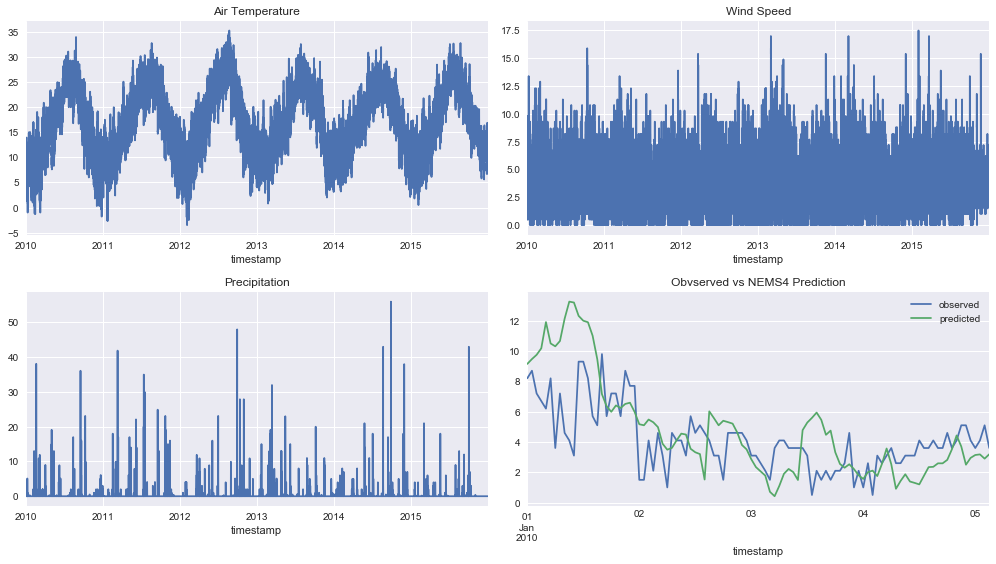

In [4]:
dataset = pd.merge(observations, nems4, left_index=True, right_index=True, how='inner')

# add time & seasonaility features
dataset['hour'] = np.floor(dataset.index.hour / 4) + 1
dataset['month'] = np.floor(dataset.index.month) + 1

plt.figure(figsize=(14, 8))

plt.subplot(221)
dataset.AT.plot()
plt.title('Air Temperature')

plt.subplot(222)
dataset.wind_speed.plot()
plt.title('Wind Speed')

plt.subplot(223)
dataset.precipitation.plot()
plt.title('Precipitation')

plt.subplot(224)
dataset[:100].wind_speed.plot(label='observed')
dataset[:100].nems4_wind_speed.plot(label='predicted')
plt.title('Obvserved vs NEMS4 Prediction')
plt.legend()

plt.tight_layout()

In [5]:
dataset.describe()

,AT,precipitation,humidity,pressure,wind_u,wind_v,wind_speed,nems4_AT,nems4_precipitation,nems4_humidity,nems4_pressure,nems4_wind_u,nems4_wind_v,nems4_wind_speed,hour,month
count,52576.000000,52576.000000,52576.000000,52576.000000,52576.000000,52576.000000,52576.000000,52576.000000,52576.000000,52576.000000,52576.000000,52576.000000,52576.000000,52576.000000,52576.000000,52576.000000
mean,16.965693,0.075126,69.198988,1016.498383,0.509687,-0.773462,4.090477,16.272361,0.034725,71.348182,1016.339642,0.330596,-0.078436,3.481767,3.499696,7.523128
std,6.801571,1.017913,14.761243,7.172849,2.909983,3.450434,2.096453,6.772858,0.264269,15.966552,7.312759,2.719075,2.962051,2.039519,1.707782,3.448053
min,-3.500000,0.000000,8.000000,980.200000,-15.974775,-11.800000,0.000000,-5.840000,0.000000,11.000000,982.000000,-17.816017,-17.588400,0.000000,1.000000,2.000000
25%,11.900000,0.000000,60.000000,1012.600000,-0.364661,-3.545308,2.600000,11.270000,0.000000,60.000000,1012.000000,-1.071080,-2.100556,1.940000,2.000000,5.000000
50%,16.900000,0.000000,71.000000,1016.900000,0.798782,-1.231273,4.100000,16.450000,0.000000,73.000000,1017.000000,0.497157,-0.304338,3.100000,3.000000,8.000000
75%,22.600000,0.000000,80.000000,1020.700000,1.991716,2.068096,5.100000,21.500000,0.000000,84.000000,1021.000000,1.822884,2.099368,4.660000,5.000000,11.000000
max,35.300000,56.000000,100.000000,1041.600000,16.444621,9.353074,17.500000,39.210000,16.000000,100.000000,1044.000000,13.232996,10.681924,22.320000,6.000000,13.000000


### Sanity Check NEMS4 against Observations

Compute the error scores for nems4 vs observations. Use linear regression to calculate the linear transformation (intercept plus scaling factor) between the nems4 model and the observations.

We can use cross correlation to determine if signals are in phase or shifted. Change the series to induce a time shift to validate that it is being detected correctly (we did and if we shift by an additional 12 hours it detects the exact 12 hour shift). However it always detects a 2 hour shift..

In [6]:
y_real = dataset.wind_speed.values
y_pred = dataset.nems4_wind_speed.values

#### Phase of Signals

In [7]:
import numpy as np
from scipy.signal import correlate

xcorr = correlate(y_real, y_pred)

# delta time array to match xcorr
dt = np.arange(1-len(y_real), len(y_real))

detected_shift = dt[xcorr.argmax()]

print("Detected time shift of {} hours".format(detected_shift))

Detected time shift of 0 hours


#### Error between Signals

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def print_error_metrics(observed, predicted):
    # lets get some stats on the test predictions
    mse = mean_squared_error(observed, predicted)
    rmse = sqrt(mse)
    mae = mean_absolute_error(observed, predicted)
    print('\nTest MSE: {:.4f} RMSE: {:.4f} and MAE {:.4f}'.format(mse, rmse, mae))
    print("Correlation: {:.4f}".format(np.corrcoef(observed, predicted)[1,0]))
    print(pd.DataFrame(np.abs(observed-predicted)).describe())
    


print_error_metrics(y_real, y_pred)


Test MSE: 4.3405 RMSE: 2.0834 and MAE 1.6213
Correlation: 0.5361
                  0
count  52576.000000
mean       1.621267
std        1.308438
min        0.000000
25%        0.620000
50%        1.320000
75%        2.300000
max       16.620000


#### Visualise signals 

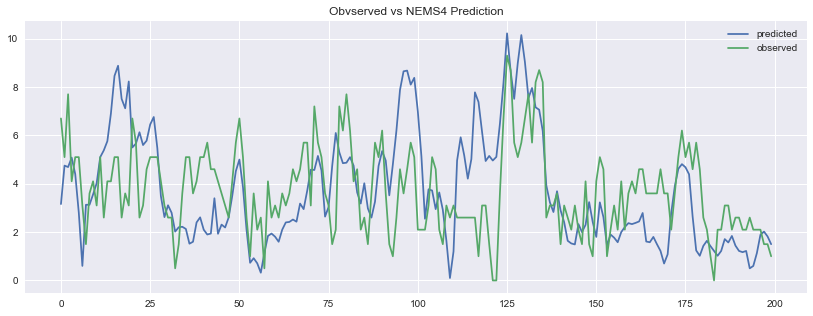

In [9]:
plt.figure(figsize=(14, 5))

plt.plot(y_pred[200:400], label='predicted')
plt.plot(y_real[200:400], label='observed')
plt.title('Obvserved vs NEMS4 Prediction')
plt.legend()

#### Compare Scaled Signal via Linear Regression

Use linear regression to calculate the linear transformation (intercept plus scaling factor) between the nems4 model and the observations.

In [10]:
from sklearn import linear_model
 
lr = linear_model.LinearRegression()

split = int(len(y_pred) * 0.8)
 
lr.fit(y_pred[:-split].reshape(-1,1), y_real[:-split])
 
# Make predictions using the testing set
scaled_y_pred = lr.predict(y_pred[-split:].reshape(-1,1))
 
print('Coefficient: \n', lr.coef_,'\n intercept: \n', lr.intercept_)
 
print("MAE before linear transform was {:.4f}, after {:.4f}".format(
    mean_absolute_error(y_real[-split:], y_pred[-split:]),
    mean_absolute_error(y_real[-split:], scaled_y_pred)))

Coefficient: 
 [ 0.54572027] 
 intercept: 
 2.16707634696
MAE before linear transform was 1.6270, after 1.3884
